In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

In [3]:
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

nmin=0
nmax=2000
#Select quality 0 Z->mumu
Zmumu_pt=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin:nmax]
Zmumu_eta=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin:nmax]
Zmumu_phi=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin:nmax]
#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)
#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]
ZeroBias_e=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_e"].array())[nmin:nmax]

quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


100%|██████████| 2000/2000 [00:01<00:00, 1355.34it/s]


energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


In [4]:

#Set dr
dr_min=0.05
dr_max=0.3
#Compute isolation
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax])
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax])
#Compute ratio
data1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)
data2=ak.flatten(res2)/ak.flatten(Zmumu_pt)

In [5]:
d1=data1[data1/data1 == 1]
d2=data2[data2/data2 == 1]

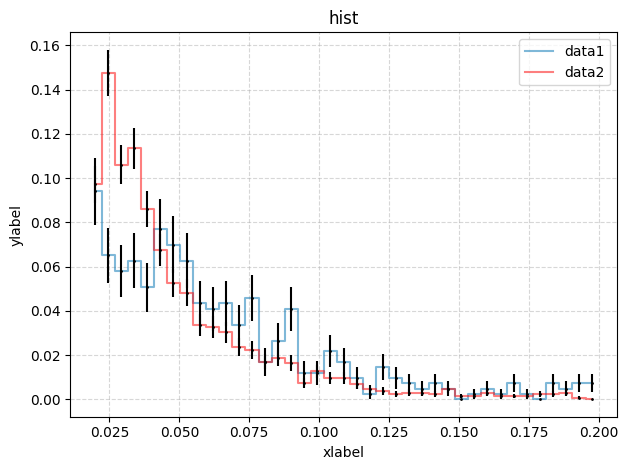

In [32]:
coolplot([d1, d2], np.linspace(0.0175,0.2,40), collect_overflow=False)

In [7]:
mask=data1/data1 == 1
print(data1[mask]) 
print(ak.flatten(res1)[mask])
print(ak.flatten(ZeroBias_pt)[mask])

[0.0338, 0.188, 0.0487, 0.198, 0.0834, ..., 0.0722, 0.00524, 0.0103, 0.109]
[1.52e+03, 3.7e+03, 800, 3.25e+03, ..., 1.15e+03, 1.12e+03, 1e+03, 3.42e+03]
[4.51e+04, 1.97e+04, 1.64e+04, 1.64e+04, ..., 2.15e+05, 9.74e+04, 3.15e+04]


In [22]:
d1=data1[mask]
for indices in ak.where(data1[mask] < 0.0125):
    print(data1[mask][indices]) 
    print(ak.flatten(res1)[mask][indices])
    print(ak.flatten(ZeroBias_pt)[mask][indices])
    print(ak.flatten(ZeroBias_eta)[mask][indices])
    print(ak.flatten(ZeroBias_phi)[mask][indices])

[0.00885, 0.000939, 0.00322, 0.00135, ..., 0.0103, 0.00819, 0.00524, 0.0103]
[1.08e+03, 2.45e+03, 1.42e+03, 1.12e+03, ..., 2.18e+03, 650, 1.12e+03, 1e+03]
[1.21e+05, 2.61e+06, 4.43e+05, 8.34e+05, ..., 7.94e+04, 2.15e+05, 9.74e+04]
[-1.75, -1.45, -1.4, -2.35, -0.968, 2.54, ..., -0.765, -2.5, 2.34, -1.52, 2.43]
[1.13, 1.39, 2.92, 0.538, -1.77, -1.25, ..., -2.94, -3.05, 0.66, 3.11, -2.37]


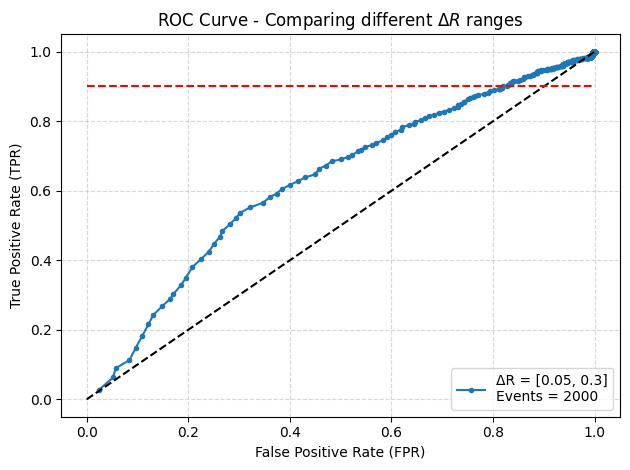

[[<Array [0.0248, 0.052, 0.0569, 0.0842, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0.0278, 0.0631, 0.0894, 0.113, ..., 1, 1, 1, 1] type='999 * float64'>]]

In [39]:
plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta, ZeroBias_phi,
               [nmin, nmax],[nmin,nmax], np.linspace(0.02,1,1000), [dr_min], [dr_max])